
# Тема: Диагностика переобучения модели и борьба с ним на примере решающего дерева

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import  DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import cross_validate

from sklearn.model_selection import validation_curve, learning_curve

### 1. Загрузите датасет `titanic.csv` и выведите первые 5 строк. Отдедите целевую переменную 'Survived' и обозначьте данные за `X`, а целевую переменную за `y`. Выведите их размеры.

In [ ]:
df = pd.read_csv('titanic.csv')
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,0,22.0,1,0,7.2500,0,0,1
1,2,1,1,1,38.0,1,0,71.2833,1,0,0
2,3,1,3,1,26.0,0,0,7.9250,0,0,1
3,4,1,1,1,35.0,1,0,53.1000,0,0,1
4,5,0,3,0,35.0,0,0,8.0500,0,0,1


In [ ]:
y = df['Survived'].values
x = df.drop(['Survived', 'PassengerId'], axis = 1).values
x[:5]

array([[ 3.    ,  0.    , 22.    ,  1.    ,  0.    ,  7.25  ,  0.    ,
         0.    ,  1.    ],
       [ 1.    ,  1.    , 38.    ,  1.    ,  0.    , 71.2833,  1.    ,
         0.    ,  0.    ],
       [ 3.    ,  1.    , 26.    ,  0.    ,  0.    ,  7.925 ,  0.    ,
         0.    ,  1.    ],
       [ 1.    ,  1.    , 35.    ,  1.    ,  0.    , 53.1   ,  0.    ,
         0.    ,  1.    ],
       [ 3.    ,  0.    , 35.    ,  0.    ,  0.    ,  8.05  ,  0.    ,
         0.    ,  1.    ]])

In [ ]:
x.shape, y.shape

((891, 9), (891,))

### 2. Сделайте 10-блочную перекрёстную проверку (кросс-валидацию) модели DecisionTreeClassifier(random_state=3) с вычислением двух метрик accuracy и F1, используя библиотечную функцию cross_validate. Установите значение параметра return_train_score этой функции True для того, чтобы выводились значения метрик не только на тестовых данных, но и на обучающих тоже. Результаты выведите в виде двух датафреймов, оставив в первом только два столбца со значениями метрики accuracy на обучающих и тестовых данных, а во втором со значениями метрики F1.

In [ ]:
clf = DecisionTreeClassifier(random_state=3)
cv_results = cross_validate(clf, x, y, cv = 10, scoring = ['accuracy', 'f1_macro'], return_train_score = True)
pd.DataFrame(cv_results)

,fit_time,score_time,test_accuracy,train_accuracy,test_f1_macro,train_f1_macro
0,0.002682,0.001826,0.700000,0.977528,0.688900,0.976018
1,0.002052,0.001526,0.775281,0.978803,0.759199,0.977412
2,0.001808,0.000886,0.741573,0.982544,0.708446,0.981435
3,0.001672,0.000915,0.764045,0.976309,0.753982,0.974687
4,0.001840,0.000837,0.831461,0.977556,0.822497,0.976068
5,0.001677,0.000816,0.752809,0.980050,0.741005,0.978755
6,0.001672,0.000759,0.808989,0.976309,0.788006,0.974721
7,0.001472,0.000768,0.764045,0.976309,0.738125,0.974687
8,0.001512,0.000792,0.842697,0.976309,0.838098,0.974721
9,0.001488,0.000770,0.797753,0.977556,0.785829,0.976004


In [ ]:
scores_accuracy = pd.DataFrame(cv_results)[['train_accuracy', 'test_accuracy']]
scores_accuracy

,train_accuracy,test_accuracy
0,0.977528,0.700000
1,0.978803,0.775281
2,0.982544,0.741573
3,0.976309,0.764045
4,0.977556,0.831461
5,0.980050,0.752809
6,0.976309,0.808989
7,0.976309,0.764045
8,0.976309,0.842697
9,0.977556,0.797753


In [ ]:
scores_f1 = pd.DataFrame(cv_results)[['train_f1_macro', 'test_f1_macro']]
scores_f1

,train_f1_macro,test_f1_macro
0,0.976018,0.688900
1,0.977412,0.759199
2,0.981435,0.708446
3,0.974687,0.753982
4,0.976068,0.822497
5,0.978755,0.741005
6,0.974721,0.788006
7,0.974687,0.738125
8,0.974721,0.838098
9,0.976004,0.785829


### 3. Найдите средние значения метрики accuracy на обучающих и на тестовых данных. Сравните эти значения между собой и сделайте предположение о переобученности модели. Проделайте аналогичные действия со значениями метрики F1.

In [ ]:
scores_accuracy.mean(axis = 0)

train_accuracy    0.977927
test_accuracy     0.777865
dtype: float64

In [ ]:
scores_f1.mean(axis = 0)

train_f1_macro    0.976451
test_f1_macro     0.762409
dtype: float64

### 4. Визуализируйте для метрик accuracy и F1 полученные результаты перекрёстной-проверки, написав функцию plot_cv_scores, которая строит значения метрик на обучающих и тестовых данных для каждого блока. Убедитесь по графикам, что имеет место переобучение, т.к. ломаные линии для обучающих и тестовых данных не пересекаются.

In [ ]:
def plot_cv_scores(scores, scoring):
  plt.figure(figsize = (6, 4))
  plt.plot(scores.iloc[:, 0], label = 'train', marker = '.')
  plt.plot(scores.iloc[:, 1], label = 'test', marker = '.')
  plt.axhline(y = 1, color = 'black', ls = 'dashed')
  plt.title('Визуализация кросс-валидации')
  plt.xlabel('Итерации кросс-валидации')
  plt.ylabel(scoring)
  plt.legend()
  plt.show()

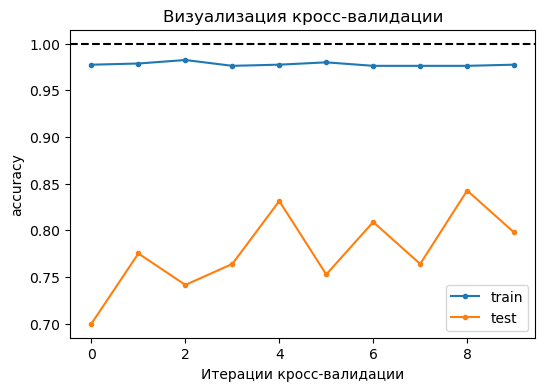

In [ ]:
plot_cv_scores(scores_accuracy, 'accuracy')

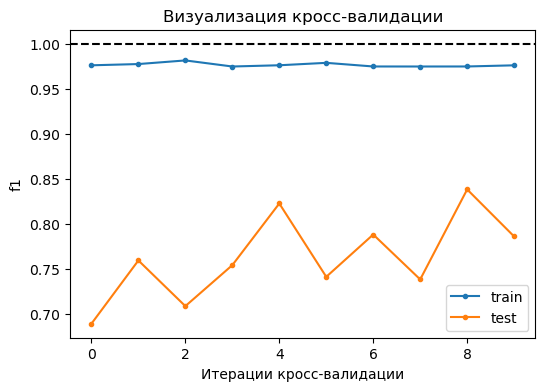

In [ ]:
plot_cv_scores(scores_f1, 'f1')

### 5. Поборитесь с переобучением в этой задаче, для этого варьируйте значение гиперпараметра max_depth (он является параметром регуляризации для дерева решений) и постройте соответствующую ***кривую проверки***, вычислив необходимые для её построения значения при помощи функции validation_curve. Используйте метрический показатель F1. Глядя на график, определите оптимальное значение  max_depth.

In [ ]:
max_depth = np.arange(1, 11)
max_depth

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [ ]:
train_scores, test_scores = validation_curve(clf, x, y,
                                             param_name = 'max_depth', param_range = max_depth,
                                             cv =5, scoring = 'f1_macro')
train_scores, test_scores

(array([[0.76503901, 0.76599142, 0.77070463, 0.78112647, 0.77106886],
        [0.75414306, 0.73539364, 0.78540256, 0.79658894, 0.77106886],
        [0.80686662, 0.80802534, 0.81107255, 0.81948886, 0.79377744],
        [0.81061376, 0.82249076, 0.82264594, 0.82366938, 0.8037957 ],
        [0.84168983, 0.83955502, 0.82738408, 0.84173761, 0.84127066],
        [0.85232173, 0.85289805, 0.83711347, 0.86577795, 0.857739  ],
        [0.87173092, 0.87706709, 0.84847184, 0.88523028, 0.87626646],
        [0.88657246, 0.88282919, 0.86408186, 0.90359344, 0.89513924],
        [0.91186012, 0.90434583, 0.88495988, 0.91246239, 0.90017641],
        [0.91911571, 0.9143808 , 0.89798387, 0.93026806, 0.91453035]]),
 array([[0.79307725, 0.78994572, 0.77123918, 0.72775306, 0.76977536],
        [0.67760656, 0.75537644, 0.77262337, 0.72775306, 0.76977536],
        [0.80260652, 0.80071247, 0.7994058 , 0.74215355, 0.80345066],
        [0.71640691, 0.81395192, 0.7926261 , 0.74746117, 0.82675195],
        [0.8013585

In [ ]:
train_scores.mean(axis = 1)

array([0.77078608, 0.76851941, 0.80784616, 0.81664311, 0.83832744,
       0.85317004, 0.87175332, 0.88644324, 0.90276093, 0.91525576])

In [ ]:
def plot_train_test_curves(train_scores, test_scores, x):
  plt.plot(x, train_scores.mean(axis = 1), label  = 'train', color = 'r')
  plt.plot(x, test_scores.mean(axis = 1), label  = 'test', color = 'g')
  plt.legend()
  plt.axhline(y = 1, color = 'black', ls = 'dashed')

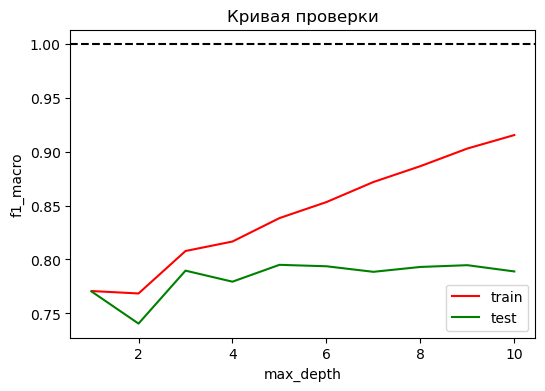

In [ ]:
plt.figure(figsize = (6,4))
plot_train_test_curves(train_scores, test_scores, max_depth)
plt.title('Кривая проверки')
plt.xlabel('max_depth')
plt.ylabel('f1_macro')
plt.show()

### 6. Сделайте 10-блочную перекрёстную проверку (кросс-валидацию) модели DecisionTreeClassifier с random_state=3 и найденным оптимальным значением max_depth, используя библиотечную функцию cross_validate. Результаты выведите в виде двух датафреймов, оставив в первом только два столбца со значениями метрики accuracy на обучающих и тестовых данных, а во втором со значениями метрики F1. Найдите средние значения метрик accuracy и F1 на обучающих и на тестовых данных.

In [ ]:
clf_opt = DecisionTreeClassifier(random_state=3, max_depth = 5)
cv_results = cross_validate(clf_opt, x, y, cv = 10, scoring = ['accuracy', 'f1_macro'], return_train_score = True)

In [ ]:
scores_accuracy = pd.DataFrame(cv_results)[['train_accuracy', 'test_accuracy']]
scores_accuracy

,train_accuracy,test_accuracy
0,0.865169,0.722222
1,0.850374,0.797753
2,0.856608,0.786517
3,0.855362,0.797753
4,0.845387,0.842697
5,0.847880,0.797753
6,0.846633,0.786517
7,0.869077,0.786517
8,0.844140,0.876404
9,0.851621,0.820225


In [ ]:
scores_f1 = pd.DataFrame(cv_results)[['train_f1_macro', 'test_f1_macro']]
scores_f1

,train_f1_macro,test_f1_macro
0,0.850487,0.694750
1,0.831880,0.769828
2,0.845945,0.763066
3,0.840069,0.790094
4,0.832305,0.833422
5,0.835502,0.777253
6,0.834519,0.759151
7,0.857233,0.754821
8,0.831581,0.866712
9,0.840361,0.811640


In [ ]:
scores_accuracy.mean(axis = 0)

train_accuracy    0.853225
test_accuracy     0.801436
dtype: float64

In [ ]:
scores_f1.mean(axis = 0)

train_f1_macro    0.839988
test_f1_macro     0.782074
dtype: float64

### 7. Убедитесь, что переобучение больше нет, построив соответствующие графики при помощи функции plot_cv_scores.

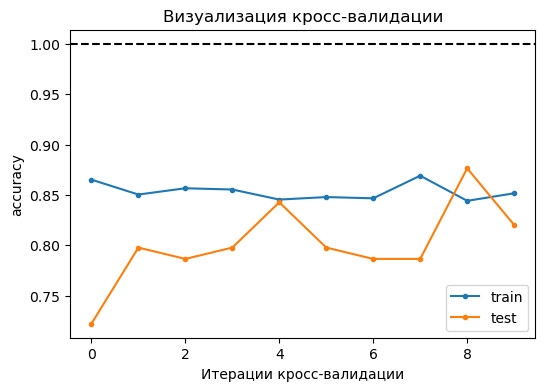

In [ ]:
plot_cv_scores(scores_accuracy, 'accuracy')

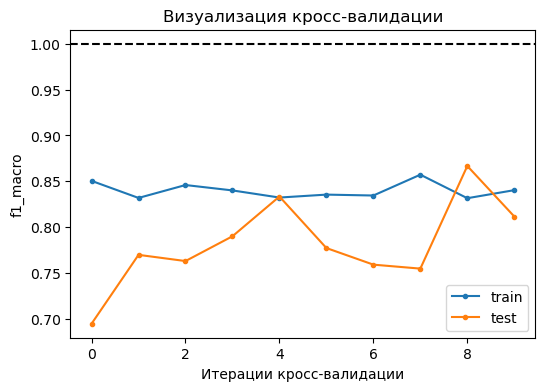

In [ ]:
plot_cv_scores(scores_f1, 'f1_macro')

1. Загрузите датасет `boston.csv` и выведите первые 5 строк. Отдедите целевую переменную 'MEDV' и обозначьте данные за `X`, а целевую переменную за `y`. Выведите их размеры.

In [ ]:
boston = pd.read_csv('boston.csv')
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [ ]:
y = boston['MEDV'].values
x = boston.drop(['MEDV'], axis = 1).values
x[:5]

array([[6.3200e-03, 1.8000e+01, 2.3100e+00, 0.0000e+00, 5.3800e-01,
        6.5750e+00, 6.5200e+01, 4.0900e+00, 1.0000e+00, 2.9600e+02,
        1.5300e+01, 3.9690e+02, 4.9800e+00],
       [2.7310e-02, 0.0000e+00, 7.0700e+00, 0.0000e+00, 4.6900e-01,
        6.4210e+00, 7.8900e+01, 4.9671e+00, 2.0000e+00, 2.4200e+02,
        1.7800e+01, 3.9690e+02, 9.1400e+00],
       [2.7290e-02, 0.0000e+00, 7.0700e+00, 0.0000e+00, 4.6900e-01,
        7.1850e+00, 6.1100e+01, 4.9671e+00, 2.0000e+00, 2.4200e+02,
        1.7800e+01, 3.9283e+02, 4.0300e+00],
       [3.2370e-02, 0.0000e+00, 2.1800e+00, 0.0000e+00, 4.5800e-01,
        6.9980e+00, 4.5800e+01, 6.0622e+00, 3.0000e+00, 2.2200e+02,
        1.8700e+01, 3.9463e+02, 2.9400e+00],
       [6.9050e-02, 0.0000e+00, 2.1800e+00, 0.0000e+00, 4.5800e-01,
        7.1470e+00, 5.4200e+01, 6.0622e+00, 3.0000e+00, 2.2200e+02,
        1.8700e+01, 3.9690e+02, 5.3300e+00]])

In [ ]:
x.shape, y.shape

((506, 13), (506,))

2. Убедитесь, что решается задача регрессии, для этого выведите количество уникальных значений целевой переменной и сравните его с общим количеством наблюдений.

In [ ]:
len(np.unique(y)), y.shape[0]

(229, 506)

Целевая переменная содержит повторяющиеся значения, это задача регрессии

3. Сделайте 7-блочную перекрёстную проверку (кросс-валидацию) модели DecisionTreeRegressor(random_state=0) с вычислением метрики neg_mean_squared_error, используя библиотечную функцию cross_validate. Установите значение параметра return_train_score этой функции True для того, чтобы выводились значения метрик не только на тестовых данных, но и на обучающих тоже. Результаты выведите в виде датафрейма, оставив только два столбца со значениями метрики на обучающих и тестовых данных, но заменив знак каждого значения на противоположный, чтобы вместо метрики neg_mean_squared_error, получалась метрика mean_squared_error.

In [ ]:
clf_boston = DecisionTreeRegressor(random_state=0)
cv_results = cross_validate(clf_boston, x, y, cv = 7, scoring = ['neg_mean_squared_error'], return_train_score = True)
pd.DataFrame(cv_results)

,fit_time,score_time,test_neg_mean_squared_error,train_neg_mean_squared_error
0,0.005037,0.000361,-12.563014,-0.0
1,0.003462,0.000360,-13.510411,-0.0
2,0.002850,0.000187,-71.290556,-0.0
3,0.002756,0.000157,-31.690139,-0.0
4,0.002651,0.000161,-10.841250,-0.0
5,0.002715,0.000157,-96.612222,-0.0
6,0.002804,0.000158,-29.507917,-0.0


In [ ]:
scores_mean_squared_error = pd.DataFrame(cv_results)[['test_neg_mean_squared_error', 'train_neg_mean_squared_error']]
scores_mean_squared_error

,test_neg_mean_squared_error,train_neg_mean_squared_error
0,-12.563014,-0.0
1,-13.510411,-0.0
2,-71.290556,-0.0
3,-31.690139,-0.0
4,-10.841250,-0.0
5,-96.612222,-0.0
6,-29.507917,-0.0


In [ ]:
scores_mean_squared_error['test_neg_mean_squared_error'] = -scores_mean_squared_error['test_neg_mean_squared_error']
scores_mean_squared_error['train_neg_mean_squared_error'] = -scores_mean_squared_error['train_neg_mean_squared_error']
scores_mean_squared_error.columns=['test_mean_squared_error', 'train_mean_squared_error']
scores_mean_squared_error

,test_mean_squared_error,train_mean_squared_error
0,12.563014,0.0
1,13.510411,0.0
2,71.290556,0.0
3,31.690139,0.0
4,10.841250,0.0
5,96.612222,0.0
6,29.507917,0.0


4. Найдите средние значения метрики mean_squared_error на обучающих и на тестовых данных. Сравните эти значения между собой и сделайте предположение о переобученности модели.

In [ ]:
scores_mean_squared_error.mean(axis = 0)

test_mean_squared_error     38.002215
train_mean_squared_error     0.000000
dtype: float64

Модель переобучена

5. Визуализируйте для метрики mean_squared_error полученные результаты перекрёстной-проверки, используя функцию plot_cv_scores. Убедитесь по графикам, что имеет место переобучение, т.к. ломаные линии для обучающих и тестовых данных не пересекаются.

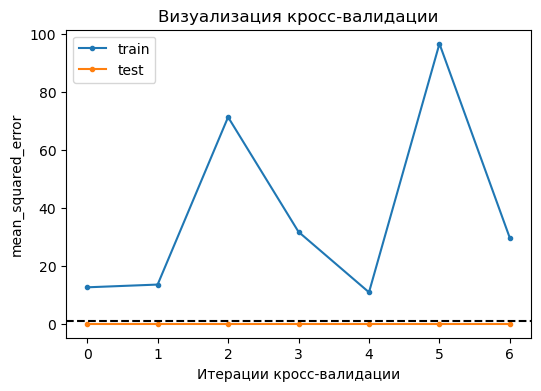

In [ ]:
plot_cv_scores(scores_mean_squared_error, 'mean_squared_error')

6. Поборитесь с переобучением, для этого варьируйте значение гиперпараметра max_depth = [1, 2, 3, 4, 5, 6]  и постройте соответствующую ***кривую проверки***, вычислив необходимые для её построения значения при помощи функции validation_curve. Используйте метрический показатель neg_mean_squared_error. Глядя на график, определите оптимальное значение  max_depth.

In [ ]:
scores_neg_mean_squared_error = pd.DataFrame(cv_results)[['test_neg_mean_squared_error', 'train_neg_mean_squared_error']]

In [ ]:
max_depth = [1, 2, 3, 4, 5, 6]
train_scores, test_scores = validation_curve(clf_boston, x, y,
                                             param_name = 'max_depth', param_range = max_depth,
                                             cv =5, scoring = 'neg_mean_squared_error')
train_scores, test_scores

(array([[-50.91509139, -47.45375901, -39.46333821, -35.64055855,
         -44.21330715],
        [-27.36845299, -26.24649951, -22.88685892, -16.72582086,
         -25.38498252],
        [-16.80806356, -14.29581196, -15.25504215, -10.99245365,
         -13.45859031],
        [ -9.72767256,  -8.15331598,  -9.05749125,  -7.68729846,
          -9.0888174 ],
        [ -6.65582749,  -5.32588279,  -6.00616753,  -5.22549852,
          -6.22949607],
        [ -4.72330444,  -3.43856357,  -4.10351323,  -3.44209584,
          -4.25477189]]),
 array([[-35.9989341 , -48.33395173, -85.66005339, -90.11563316,
         -79.578462  ],
        [-19.36290091, -25.777347  , -58.6167565 , -63.18813886,
         -41.21802825],
        [-18.59356411, -22.49318525, -41.13689802, -53.32685794,
         -42.81135374],
        [-11.94208679, -36.25334211, -29.63408807, -47.22598736,
         -65.56372677],
        [-10.26927675, -47.30522267, -22.66923462, -49.7944655 ,
         -64.0633091 ],
        [-12.594635

In [ ]:
train_scores.mean(axis = 1)

array([-43.53721086, -23.72252296, -14.16199233,  -8.74291913,
        -5.88857448,  -3.99244979])

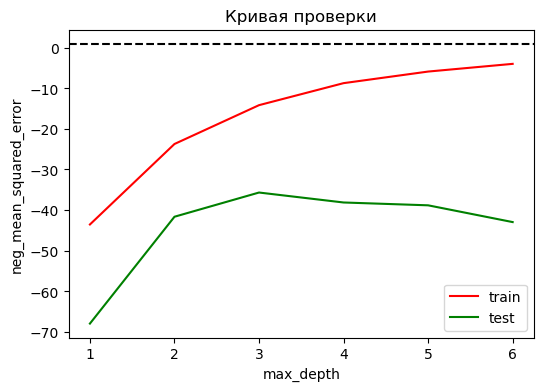

In [ ]:
plt.figure(figsize = (6,4))
plot_train_test_curves(train_scores, test_scores, max_depth)
plt.title('Кривая проверки')
plt.xlabel('max_depth')
plt.ylabel('neg_mean_squared_error')
plt.show()

7. Сделайте 7-блочную перекрёстную проверку (кросс-валидацию) модели DecisionTreeClassifier с random_state=0 и найденным оптимальным значением max_depth, используя библиотечную функцию cross_validate. Результаты выведите в виде датафрейма, оставив только два столбца со значениями метрики на обучающих и тестовых данных, заменив их знаки. Найдите среднее значение метрики mean_squared_error на обучающих и на тестовых данных.

In [ ]:
clf_boston_optimal = DecisionTreeRegressor(random_state=0, max_depth = 3)
cv_results_optimal = cross_validate(clf_boston_optimal, x, y, cv = 7, scoring = ['neg_mean_squared_error'], return_train_score = True)

In [ ]:
scores_neg_mse_optimal = pd.DataFrame(cv_results_optimal)[['test_neg_mean_squared_error', 'train_neg_mean_squared_error']]
scores_neg_mse_optimal

,test_neg_mean_squared_error,train_neg_mean_squared_error
0,-20.119622,-16.477369
1,-10.179267,-16.397745
2,-31.103173,-13.513918
3,-45.752214,-15.937971
4,-21.084571,-16.131771
5,-86.145991,-9.689361
6,-22.062352,-15.415609


In [ ]:
scores_neg_mse_optimal['test_neg_mean_squared_error'] = -scores_neg_mse_optimal['test_neg_mean_squared_error']
scores_neg_mse_optimal['train_neg_mean_squared_error'] = -scores_neg_mse_optimal['train_neg_mean_squared_error']
scores_neg_mse_optimal.columns=['test_mean_squared_error', 'train_mean_squared_error']
scores_neg_mse_optimal

,test_mean_squared_error,train_mean_squared_error
0,20.119622,16.477369
1,10.179267,16.397745
2,31.103173,13.513918
3,45.752214,15.937971
4,21.084571,16.131771
5,86.145991,9.689361
6,22.062352,15.415609


In [ ]:
scores_neg_mse_optimal.mean(axis = 0)

test_mean_squared_error     33.778170
train_mean_squared_error    14.794821
dtype: float64

8. Убедитесь, что переобучение больше нет, построив соответствующие графики при помощи функции plot_cv_scores.

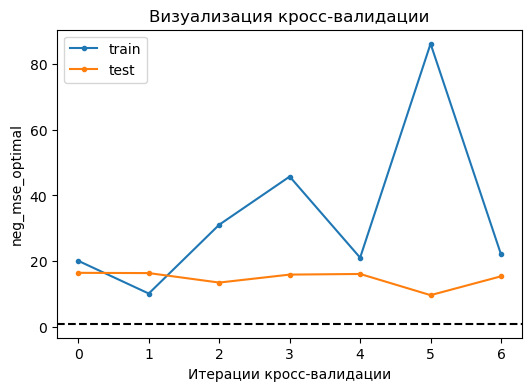

In [ ]:
plot_cv_scores(scores_neg_mse_optimal, 'neg_mse_optimal')